### Simple example
This code shows as simple way to:
- Read in a .nc file using xarray
- Calculate annual values from monthly data
- several approaches tried here, including one from https://xray.readthedocs.io/en/v0.5.2/examples/monthly-means.html

In [2]:
import xarray as xr
import cf_units as cf
import esmlab
import utils
import numpy as np
import pandas as pd
from netCDF4 import num2date
import calendar

# some resources for plotting
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
#import hvplot.xarray
#import holoviews as hv
#hv.extension('bokeh')
%matplotlib inline

var  = 'GPP'
suff = 'lnd/proc/tseries/month_1/'
path = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'+suff
file = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var +'.185001-201412.nc'
file

'/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.GPP.185001-201412.nc'

#### Read in your data

In [2]:
# wrapping the time_set_mid utility corrects time being read in by xr.open_dataset
# data sets have lots of coords, variables, and attributes
ds   = utils.time_set_mid(xr.open_dataset(file, decode_times=True), 'time')
area = ds.area
landfrac = ds.landfrac
# get a data array and find a single point for testing
da = ds[var]
da_test = da.sel(lat=40, lon=20, method='nearest')
da_test[0:12]

<xarray.DataArray 'GPP' (time: 12)>
array([1.562774e-05, 2.243951e-05, 3.100983e-05, 4.201210e-05, 5.083005e-05,
       5.120029e-05, 4.090424e-05, 1.093429e-05, 5.386169e-06, 2.389424e-05,
       1.760629e-05, 1.492977e-05], dtype=float32)
Coordinates:
    lat      float32 40.052357
    lon      float32 20.0
  * time     (time) object 1850-01-16 11:45:00 ... 1850-12-16 12:00:00
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

#### Make weights for global sum

In [3]:
landUp = area * landfrac * 1e6
orig_units = cf.Unit(landUp.attrs['units'])
target_units = cf.Unit('m^2')
landUp.attrs['units'] = target_units
#LU2 = utils.change_units(landUp, "landUp", "landUp", "m^2")
area_wgt = landUp / landUp.sum()

In [26]:
%%time

# and array for weighting monthly values
mon_day  = xr.DataArray(np.array([31,28,31,30,31,30,31,31,30,31,30,31]), dims=["month"])
mon_wgt  = mon_day/mon_day.sum()
# stride bit seems importnat here, but only seems to work with -12..., which reverse values
da_test_ann = da.rolling(time=12, center=False).construct('month', stride=-12).dot(mon_wgt).sortby('time')
#da_test_ann[0:2]

CPU times: user 676 ms, sys: 861 ms, total: 1.54 s
Wall time: 1.54 s


In [5]:
# Define days per month
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

### Define a function to make an array of days/month

In [6]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length


### Now get weights for each month

In [25]:
%%time
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(ds.time.to_index(), 
                                    calendar='noleap'),
                              coords=[ds.time], name='month_length')

# Calculate the weights by grouping by 'time.season'
weights = month_length / 365

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(165))

# Calculate the weighted average
da_weighted = (da * weights).groupby('time.year').sum(dim='time')


CPU times: user 1.09 s, sys: 896 ms, total: 1.99 s
Wall time: 1.98 s


In [61]:
# Testing to make sure we get the right answers
for offset in range(0,13):
    temp = da_test[(offset):(12+offset)]
    print((temp.data*mon_wgt.data).sum())
print("----")
temp2 = da_test[1:13]


2.725064848774521e-05
2.702783900556276e-05
2.658869458696556e-05
2.6851255354078405e-05
2.668140355811761e-05
2.6735852419459326e-05
2.6857977720955867e-05
2.691444412809924e-05
2.8209861295480338e-05
2.7992112179524393e-05
2.7456538433173975e-05
2.7494655027212126e-05
2.7335544901900784e-05
----


In [41]:
da_test_ann2 = da_test.to_dataset().resample(time='AS').mean('time')[var]
# ds_ann = ds.resample(time='AS').mean('time')
print(da_test_ann[0:10], da_test_ann2[0:10])

<xarray.DataArray (time: 10)>
array([2.725065e-05, 2.733554e-05, 2.774502e-05, 2.832905e-05, 3.061670e-05,
       3.250106e-05, 2.554712e-05, 2.433621e-05, 2.685040e-05, 2.866038e-05])
Coordinates:
    lat      float32 40.052357
    lon      float32 20.0
  * time     (time) object 1850-12-16 12:00:00 ... 1859-12-16 12:00:00 <xarray.DataArray 'GPP' (time: 10)>
array([2.723121e-05, 2.726226e-05, 2.771385e-05, 2.828145e-05, 3.056394e-05,
       3.245250e-05, 2.550745e-05, 2.432335e-05, 2.681301e-05, 2.858554e-05],
      dtype=float32)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 1859-01-01 00:00:00
    lat      float32 40.052357
    lon      float32 20.0
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean


### Try Deepak's example

In [10]:
# fake dataarray
da = xr.DataArray(np.arange(240)+1, dims=["time"], coords={"time": pd.date_range(start="2000-01-01", freq="M", periods=240)})
mon_day  = xr.DataArray(np.array([31,28,31,30,31,30,31,31,30,31,30,31]), dims=['month'])
mon_wgt  = mon_day/mon_day.sum()

print(da)
#da.rolling(time=12).construct("month")
#da.rolling(time=12, center=False).construct("month")
da.rolling(time=12, center=False).construct("month", stride=11)


<xarray.DataArray (time: 240)>
array([  1,   2,   3, ..., 238, 239, 240])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2019-12-31


<xarray.DataArray (time: 20, month: 12)>
array([[ nan,  nan,  nan, ...,  nan,  nan,   1.],
       [  2.,   3.,   4., ...,  11.,  12.,  13.],
       [ 14.,  15.,  16., ...,  23.,  24.,  25.],
       ...,
       [194., 195., 196., ..., 203., 204., 205.],
       [206., 207., 208., ..., 215., 216., 217.],
       [218., 219., 220., ..., 227., 228., 229.]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-31 2001-01-31 ... 2019-01-31
Dimensions without coordinates: month

In [ ]:
# looks like rolling starts with the first element in the last position
da.rolling(time=12, center=False).construct("month")

# We want the elements to look like [1, 2, 3, 4,... 12]
# turns out stride=11 is the right number
da.rolling(time=12, center=False).construct("month", stride=11)

# the first element is not useful, lets get rid of it by slicing
da.rolling(time=12, center=False).construct("month", stride=11).isel(time=slice(1, None))  # None means go to the end

# now weight
da.rolling(time=12, center=False).construct("month", stride=11).isel(time=slice(1, None)).dot(mon_wgt)

### now try with the function

In [13]:
dataset = da.to_dataset(name="array")  # convert the previously created unnamed DataArray to Dataset with a variable named "array"

def weighted_annual_mean(array):
    mon_day  = xr.DataArray(np.array([31,28,31,30,31,30,31,31,30,31,30,31]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

# apply iterates through all variables in a dataset and applies the function to each variable.
mean_dataset = dataset.apply(weighted_annual_mean)
mean_dataset

<xarray.Dataset>
Dimensions:  (time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2000-12-31 2001-12-31 ... 2019-12-31
Data variables:
    array    (time) float64 6.526 18.53 30.53 42.53 ... 198.5 210.5 222.5 234.5

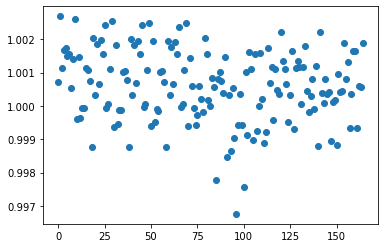

In [44]:
plt.plot(da_test_ann.data/da_test_ann2.data, 'o' );


# this code works, but may not be right...

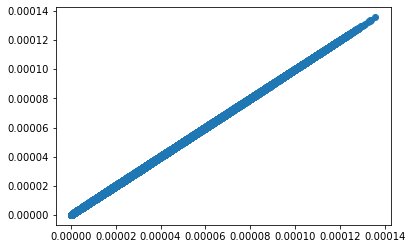

In [59]:
# data arrays strip out only the relevent coords, and attributes
# this is much faster than resampling the full dataset, but we lose landfrac and area

da_ann = da.rolling(time=12, center=False).construct('month', stride=-12).dot(mon_wgt).sortby('time')
da_ann

#print(da)
da_ann2 = da.to_dataset().resample(time='AS').mean('time')[var]
da_ann2
plt.plot(da_ann.data.flatten(),da_ann2.data.flatten(), 'o' );


In [49]:
spy = 365 * 24 * 3600
da_wgt   = da_ann * landUp * spy
ann_glob = da_wgt.sum(dim=('lat','lon')) * 1e-15 #convert to Pg/y
ann_glob.attrs['units'] = 'Pg C y^-1'

-----------------------------
#### make a line plot

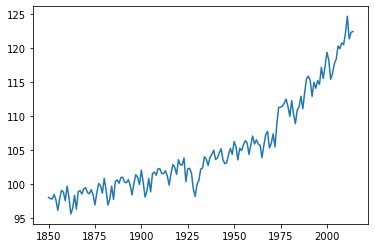

In [50]:
# set up our notebook environment so that matplotlib plots appear inline as images
%matplotlib inline
#quick plot , the `;` on the last line supresses text after executing the cell
plt.plot(ann_glob.coords['time.year'], ann_glob, '-' );


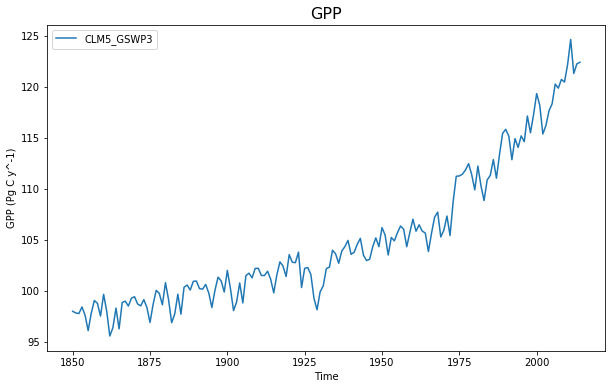

In [51]:
# Create a nicer figure
fig = plt.figure(figsize=(10, 6))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(ann_glob.coords['time.year'], ann_glob, label='CLM5_GSWP3')
# Add some labels to the plot
ax.set_xlabel('Time')
ax.set_ylabel(var+' (' + ann_glob.attrs['units'] +')')
ax.set_title(var, fontdict={'size':16})
ax.legend(loc='upper left');

------------------------
#### now make a map!

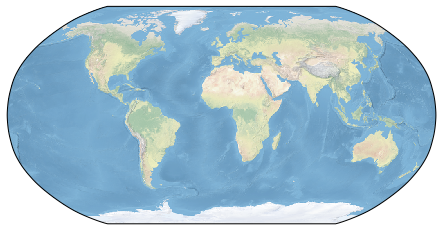

In [37]:
# Works with matplotlib's built-in transform support.
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Sets the extent to cover the whole globe
ax.set_global()

# Adds standard background map
ax.stock_img()


In [35]:
%output holomap='scrubber' fps=3
ann_glob.hvplot(x='lon', y='lat', 
              projection=ccrs.Robinson(central_longitude=0), 
              cmap='Magma')\
       .redim.range(GPP=(0, 100))


DataError: Supplied data does not contain specified dimensions, the following dimensions were not found: ['lon', 'lat']

PandasInterface expects tabular data, for more information on supported datatypes see http://holoviews.org/user_guide/Tabular_Datasets.html

In [20]:
ds2   = utils.time_set_mid(xr.open_dataset(file, decode_times=False), 'time')
ds2

<xarray.Dataset>
Dimensions:       (hist_interval: 2, lat: 192, levdcmp: 25, levgrnd: 25, levlak: 10, lon: 288, time: 1980)
Coordinates:
  * lat           (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.325 44.775
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.25 357.5 358.75
  * time          (time) float64 15.49 45.0 74.5 ... 6.018e+04 6.021e+04
Dimensions without coordinates: hist_interval
Data variables:
    BSW           (levgrnd, lat, lon) float32 ...
    DZLAKE        (levlak, lat, lon) float32 ...
    DZSOI         (levgrnd, lat, lon) float32 ...
    GPP           (time, lat, lon) float32 ...
    HKSAT         (levgrnd, lat, lon) float32 ...
    SUCSAT        (levgrnd, lat, lon) float32 ...
    WATSAT        (levgrnd, lat, lon) float3

In [21]:
ds_ann = esmlab.resample(ds2, freq='ann')
ds_ann

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'CFTimeIndex'